# ИССЛЕДОВАНИЕ ДАННЫХ HR-АГЕНТСТВА

HR-агентство изучает тренды на рынке труда в IT. Компания хочет провести исследование на основе данных о зарплатах в сфере Data Science за 2020–2022 годы и получить некоторые выводы.

## Описание столбцов
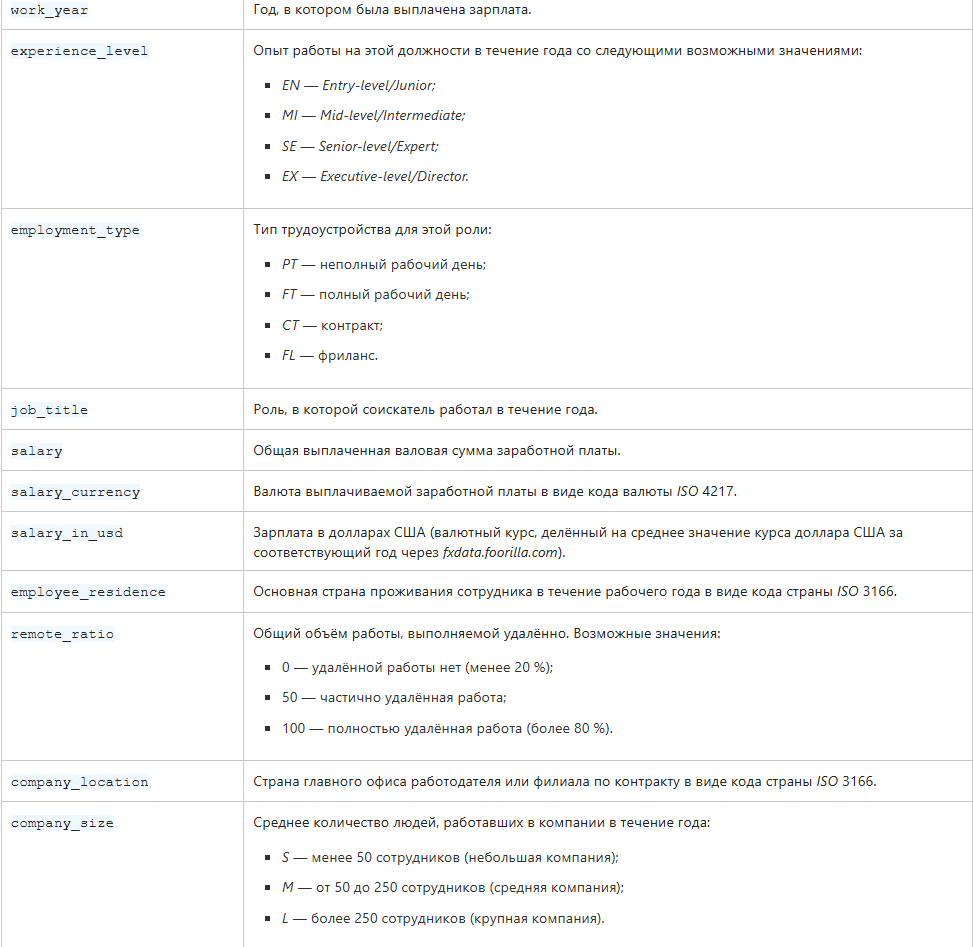


Оригинальный датасет: [“Data Science Job Salaries” (kaggle.com)](https://www.kaggle.com/datasets/ruchi798/data-science-job-salaries)

Исследуйте данные и сделайте выводы по полученным результатам. Подкрепите свои рассуждения и выводы визуализациями и с помощью статистического тестирования проверьте, являются ли выводы статистически значимыми.

В процессе своего анализа вы должны:

1. Выяснить, какие факторы влияют на зарплату специалиста Data Scientist.

2. А также ответить на ключевые вопросы HR-агентства:
- Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
- Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?
- Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?
- Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?
- Если вы найдёте в данных интересные закономерности, также отметьте их в своём анализе.

Продемонстрируйте использование разных тестов для проверки статистической значимости сделанных выводов:

- тесты для количественного признака:
  - для одной выборки;
  - для двух выборок;
  - для нескольких выборок;
- тест для категориальных признаков.

Результатом вашей работы должен стать ноутбук (IPYNB-файл) с кодом для исследования, а также с выводами и рассуждениями, полученными на основе разведывательного анализа.

В качестве ответа вставьте в форму ниже файл в формате IPYNB. Ментор проверит ваше решение, поставит оценку и даст комментарии.


In [3]:
#Подгружаем данные и нужные библиотеки
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels import stats as sms
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce 
import plotly
import plotly.express as px


alpha = 0.05

sal_df = pd.read_csv('data/ds_salaries.csv', sep=',', index_col=0)
display(sal_df)

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L
...,...,...,...,...,...,...,...,...,...,...,...
602,2022,SE,FT,Data Engineer,154000,USD,154000,US,100,US,M
603,2022,SE,FT,Data Engineer,126000,USD,126000,US,100,US,M
604,2022,SE,FT,Data Analyst,129000,USD,129000,US,0,US,M
605,2022,SE,FT,Data Analyst,150000,USD,150000,US,100,US,M


## Раздел 0. Исследуйте данные и сделайте выводы по полученным результатам. Подкрепите свои рассуждения и выводы визуализациями и с помощью статистического тестирования проверьте, являются ли выводы статистически значимыми.

### 0.1. проверяем датафрейм на количество дубликатов

In [407]:
#проверяем количество дубликатов
print('Количество дубликатов: {}'.format(sal_df[sal_df.duplicated()].shape[0]))

#Удаляем дубликаты, копируя датасет
sal_data = sal_df.drop_duplicates()

#проверяем колисетво строк в датасетах ДО и после удаления
print(sal_df.shape[0])
print(sal_data.shape[0])

Количество дубликатов: 42
607
565


### 0.2. Проверяем нормальность распределения зарплаты

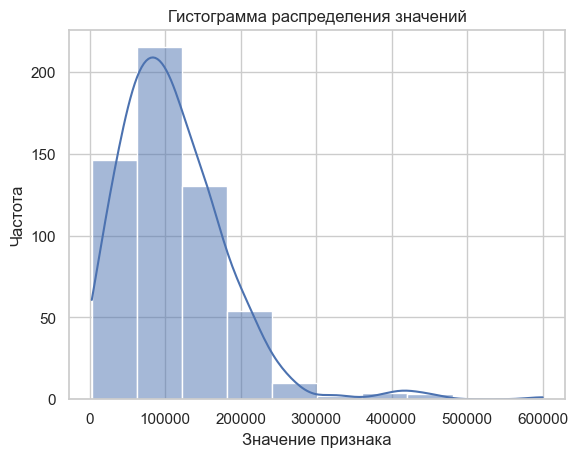

In [408]:

# Визуальная проверка на нормальность распределения признака
ax = sns.histplot(sal_data['salary_in_usd'], bins=10, kde=True)
ax.set(xlabel='Значение признака', ylabel='Частота')
plt.title('Гистограмма распределения значений')
plt.show()

In [409]:
#проверка на нормальность - тест Шапиро-Уилка
_, p = stats.shapiro(sal_data['salary_in_usd'])
print('p-value = %.3f' % (p))

#интерпретируем результат
if p <= alpha:
    print('Распределение не нормальное')
else:
    print('Распределение нормальное')    

p-value = 0.000
Распределение не нормальное


## Вывод по разделу 0:

- Исключены дубликаты (42 строки)
- Проверка нормальности распределения зарплаты показывает, признак 'salary_in_usd' распределён не нормально

## Раздел 1. Выяснить, какие факторы влияют на зарплату специалиста Data Scientist.

### 1.1. Для проверки корреляций признаков, выполним замену категориальных признаков (experience_level, employment_type', company_size) на числовые значения:

1. **experience_level:**
    - ***EN = 1*** — Entry-level/Junior;
    - ***MI = 2*** — Mid-level/Intermediate;
    - ***SE = 3*** — Senior-level/Expert;
    - ***EX = 4*** — Executive-level/Directo

2. **employment_type:**
    - ***PT = 1*** — неполный рабочий день;
    - ***FT = 2*** — полный рабочий день;
    - ***CT = 3*** — контракт;
    - ***FL = 4*** — фриланс.

3. ***company_size:***
    - ***S = 1*** — менее 50 сотрудников (небольшая компания);
    - ***M = 2*** — от 50 до 250 сотрудников (средняя компания);
    - ***L = 3*** — более 250 сотрудников (крупная компания).   

In [410]:
# Создаём схемы замены признаков

#Опыт работы
exp_map = ce.OrdinalEncoder(mapping=[{
	'col': 'experience_level',
	'mapping': {'EN': 1, 'MI': 2, 'SE': 3, 'EX': 4}
}])

#Тип трудоустройства
empl_map = ce.OrdinalEncoder(mapping=[{
	'col': 'employment_type',
	'mapping': {'PT': 1, 'FT': 2, 'CT': 3, 'FL': 4}
}])

#Размер компании
c_size_map = ce.OrdinalEncoder(mapping=[{
	'col': 'company_size',
	'mapping': {'S': 1, 'M': 2, 'L': 3}
}])

data_exp = exp_map.fit_transform(sal_data[['experience_level']])

data_empl = empl_map.fit_transform(sal_data[['employment_type']])

data_c_size = c_size_map.fit_transform(sal_data[['company_size']])



### 1.2. Удаляем предыдущие признаки (experience_level, employment_type', company_size), добавляем обновлённые (числовые)

In [411]:
sal_data = sal_data.drop(['experience_level', 'employment_type', 'company_size'], axis=1)
sal_data = pd.concat([sal_data, data_exp, data_empl, data_c_size], axis=1)
sal_data

,work_year,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,experience_level,employment_type,company_size
0,2020,Data Scientist,70000,EUR,79833,DE,0,DE,2,2,3
1,2020,Machine Learning Scientist,260000,USD,260000,JP,0,JP,3,2,1
2,2020,Big Data Engineer,85000,GBP,109024,GB,50,GB,3,2,2
3,2020,Product Data Analyst,20000,USD,20000,HN,0,HN,2,2,1
4,2020,Machine Learning Engineer,150000,USD,150000,US,50,US,3,2,3
...,...,...,...,...,...,...,...,...,...,...,...
602,2022,Data Engineer,154000,USD,154000,US,100,US,3,2,2
603,2022,Data Engineer,126000,USD,126000,US,100,US,3,2,2
604,2022,Data Analyst,129000,USD,129000,US,0,US,3,2,2
605,2022,Data Analyst,150000,USD,150000,US,100,US,3,2,2


### 1.3. Выполним сначала визуальную проверку зависимости зарплаты от следующих признаков (experience_level, employment_type, company_size, work_year, remote_ratio)

Text(0.5, 1.0, 'Зарплата/Общий объём работы, выполняемой удалённо')

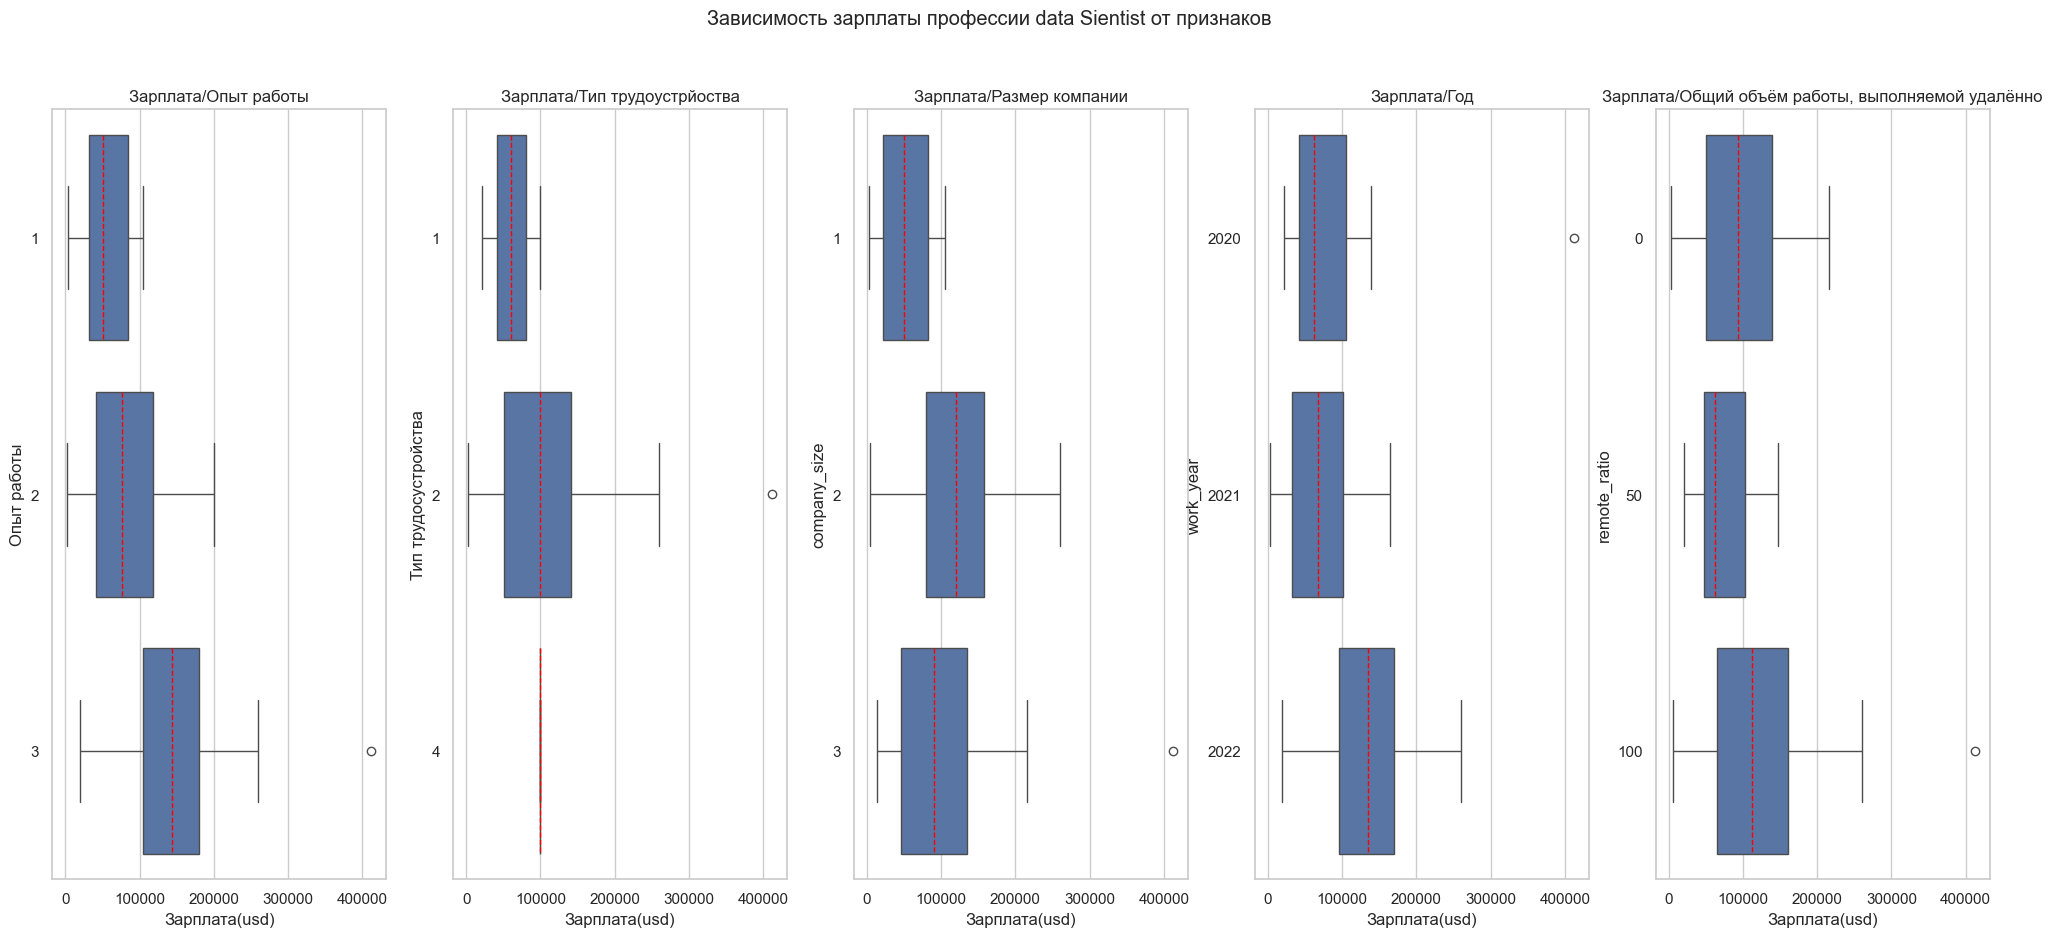

In [443]:
# Маска обновлянного датасета (категориальные признаки выражены в числах)
mask_DS = sal_data[(sal_data['job_title'] == 'Data Scientist')]

# Создаём блок схем
fig, axes = plt.subplots(1, 5, figsize=(25,10))
fig.suptitle('Зависимость зарплаты профессии data Sientist от признаков')

#Графики зависимости зарплаты (usd) Дата Сиентистов
ax1 = sns.boxplot(data = mask_DS, x='salary_in_usd', y='experience_level', orient='h', medianprops={"color": "red", "linestyle": '--'}, ax = axes[0])
ax1.set(xlabel='Зарплата(usd)', ylabel='Опыт работы')
ax1.set_title('Зарплата/Опыт работы')


ax2 = sns.boxplot(mask_DS, x='salary_in_usd', y='employment_type', orient='h', medianprops={"color": "red", "linestyle": '--'}, ax = axes[1])
ax2.set(xlabel='Зарплата(usd)', ylabel='Тип трудосустройства')
ax2.set_title('Зарплата/Тип трудоустрйоства')


ax3 = sns.boxplot(mask_DS, x='salary_in_usd', y='company_size', orient='h', medianprops={"color": "red", "linestyle": '--'}, ax = axes[2])
ax3.set(xlabel='Зарплата(usd)', ylabel='company_size')
ax3.set_title('Зарплата/Размер компании')


ax4 = sns.boxplot(mask_DS, x='salary_in_usd', y='work_year', orient='h', medianprops={"color": "red", "linestyle": '--'}, ax = axes[3])
ax4.set(xlabel='Зарплата(usd)', ylabel='work_year')
ax4.set_title('Зарплата/Год')


ax5 = sns.boxplot(mask_DS, x='salary_in_usd', y='remote_ratio', orient='h', medianprops={"color": "red", "linestyle": '--'}, ax = axes[4])
ax5.set(xlabel='Зарплата(usd)', ylabel='remote_ratio')
ax5.set_title('Зарплата/Общий объём работы, выполняемой удалённо')



### 1.4. Выполним проверку кореляции по Спирмену зависимости зарплаты от следующих признаков (experience_level, employment_type, company_size, work_year, remote_ratio)

In [413]:
#Создаем маска для вычисления коэффициента корреляции

mask_exp = mask_DS[['salary_in_usd','experience_level']]
mask_empl = mask_DS[['salary_in_usd','employment_type']]
mask_c_size = mask_DS[['salary_in_usd','company_size']]
mask_work_year = mask_DS[['salary_in_usd','work_year']]
mask_ratio = mask_DS[['salary_in_usd','remote_ratio']]

#Вычисляем коэффициент корреляции

display(round(mask_exp.corr(method = 'spearman'),2))
display(round(mask_empl.corr(method = 'spearman'),2))
display(round(mask_c_size.corr(method = 'spearman'),2))
display(round(mask_work_year.corr(method = 'spearman'),2))
display(round(mask_ratio.corr(method = 'spearman'),2))

,salary_in_usd,experience_level
salary_in_usd,1.00,0.61
experience_level,0.61,1.00


,salary_in_usd,employment_type
salary_in_usd,1.00,0.08
employment_type,0.08,1.00


,salary_in_usd,company_size
salary_in_usd,1.00,0.14
company_size,0.14,1.00


,salary_in_usd,work_year
salary_in_usd,1.00,0.47
work_year,0.47,1.00


,salary_in_usd,remote_ratio
salary_in_usd,1.00,0.15
remote_ratio,0.15,1.00


## Вывод по разделу 1:
- После визуальной оценки можно заметить, что наибольшее отклонение медиан наблюдается в признаках ***experience_level*** и ***work_year***
- Проверка кореляции по Спирмену подтверждает визуальную оценку:

    ***- salary_in_usd/experience_level*** - 0.61 (средняя связь)

    ***- salary_in_usd/employment_type*** - 0.08 (нет связи)

    ***- salary_in_usd/company_size*** - 0.14 (нет связи)

    ***- salary_in_usd/work_year*** - 0.47 (слабая) связь

    ***- salary_in_usd/remote_ratio*** - 0.15 (нет связи)

## Раздел 2.1. Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?

### 2.1.1. Для проверки гипотизы о ежегодном росте зарплат, необходимо сделать выборку.

В нашем случае выборка будет состоять из 10 значений в трех независимых группах.


In [414]:
#Создаем маски выборок

mask_DS_2020 = mask_DS[(mask_DS['work_year'] == 2020)]
mask_DS_2021 = mask_DS[(mask_DS['work_year'] == 2021)]
mask_DS_2022 = mask_DS[(mask_DS['work_year'] == 2022)]

### 2.1.2. В данном подразделе проверим гипотезу о ежегодном росте зарплат для специалистов data science

Нулевая гипотеза для двух и более групп будет выглядеть следующим образом:

***m1 = m2 = m3***

Альтернативная гипотеза:

***m1 ≠ m2 ≠ m3***

Так как признак *salary_in_usd* распределён не нормально - **воспользуемся тестом Краскела-Уоллиса**

In [415]:
# проводим тест
_, p = stats.kruskal(mask_DS_2020['salary_in_usd'][:20], mask_DS_2021['salary_in_usd'][:20], mask_DS_2022['salary_in_usd'][:20])

print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.


### 2.1.3. Скорректируем выборку и проверим нулевую гипотезу.

Отфильтруем специалистов data science по рангам, а в тесте **Краскела-Уоллиса** будем изпользовать выборку специалистов одного ранга ***(в нашем случае ранга 2 = MI)***



In [416]:
#Корректируем маски выборок

mask_DS_2020_el = mask_DS_2020[(mask_DS_2020['experience_level'] == 2)][:10]
mask_DS_2021_el = mask_DS_2021[(mask_DS_2021['experience_level'] == 2)][:10]
mask_DS_2022_el = mask_DS_2022[(mask_DS_2022['experience_level'] == 2)][:10]

# проводим тест
_, p = stats.kruskal(mask_DS_2020_el['salary_in_usd'], mask_DS_2021_el['salary_in_usd'], mask_DS_2022_el['salary_in_usd'])

print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))



p-value = 0.490
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


Text(0.5, 1.0, 'Выборка 2: Специалисты одного ранга')

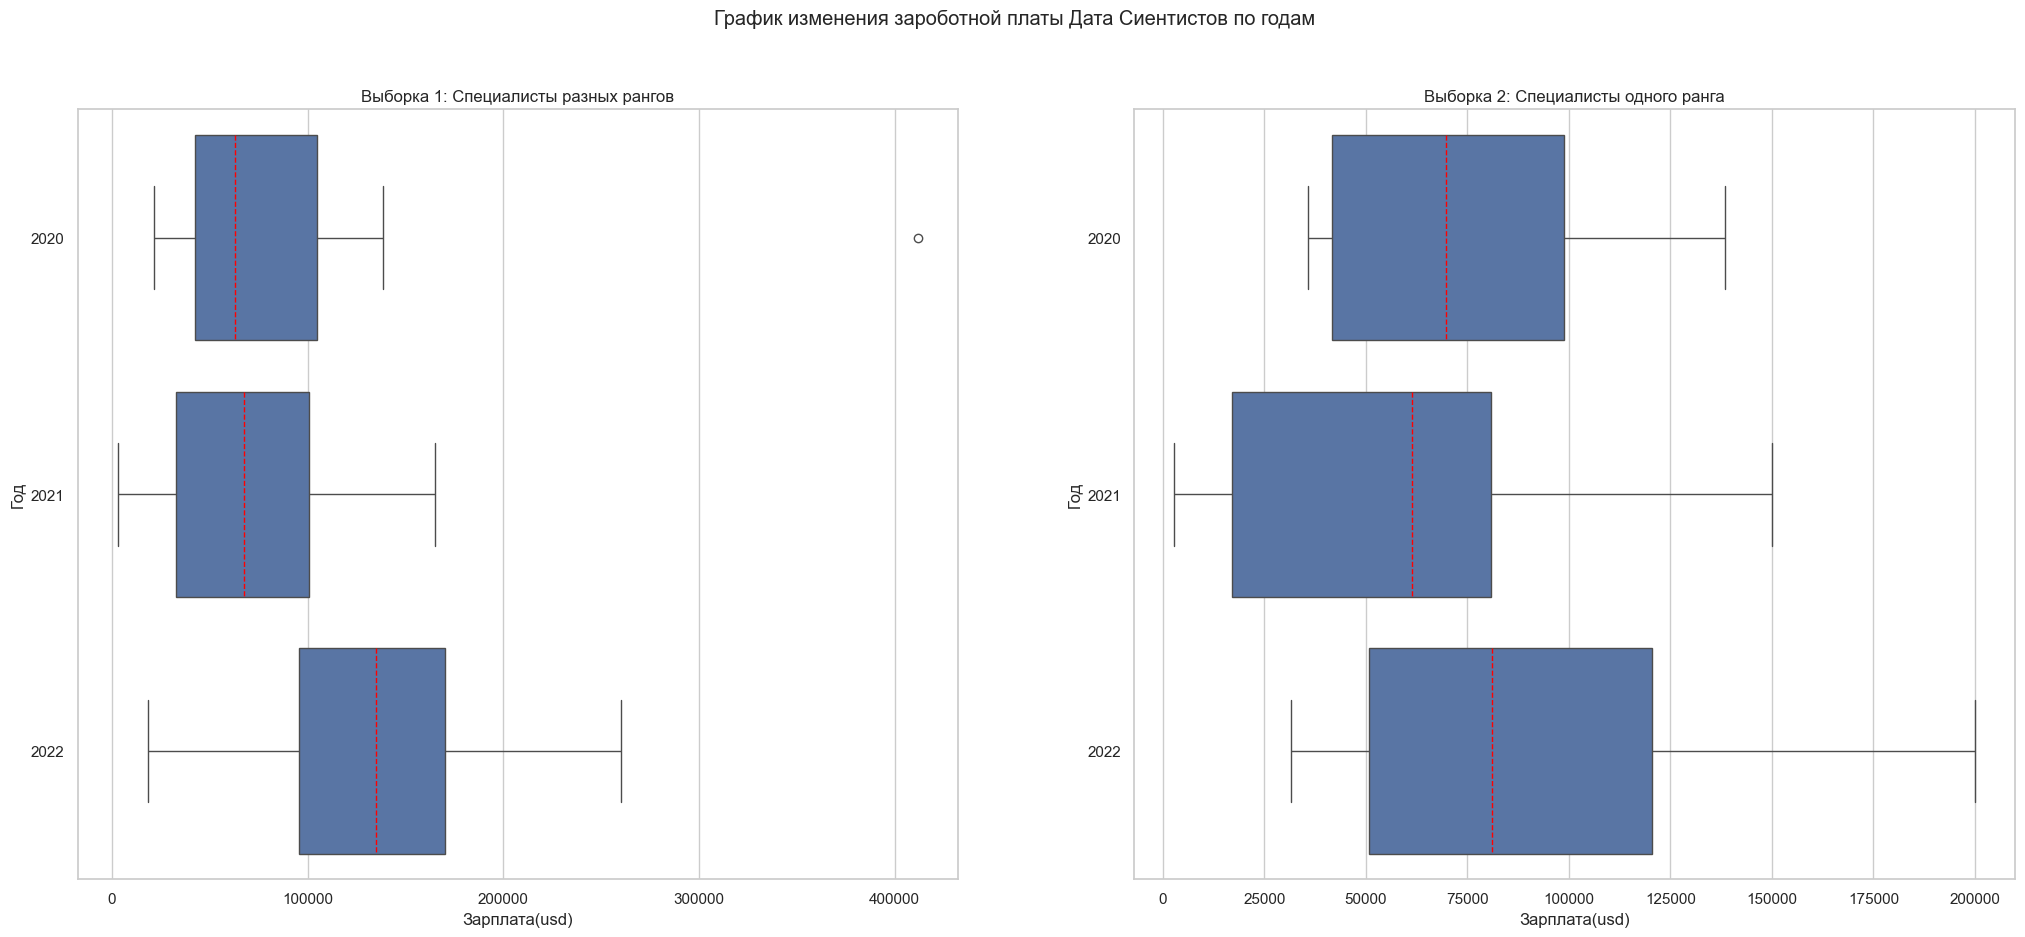

In [417]:
DS_concat = pd.concat(
    [mask_DS_2020, mask_DS_2021, mask_DS_2022],
    ignore_index=True
)

DS_concat_el = pd.concat(
    [mask_DS_2020_el, mask_DS_2021_el, mask_DS_2022_el],
    ignore_index=True
)


# Создаём блок схем
fig, axes = plt.subplots(1, 2, figsize=(25,10))
fig.suptitle('График изменения зароботной платы Дата Сиентистов по годам')

#Графики зависимости зарплаты (usd) Дата Сиентистов
ax1 = sns.boxplot(data = DS_concat, x='salary_in_usd', y='work_year', orient='h', medianprops={"color": "red", "linestyle": '--'}, ax = axes[0])
ax1.set(xlabel='Зарплата(usd)', ylabel='Год')
ax1.set_title('Выборка 1: Специалисты разных рангов')


ax2 = sns.boxplot(DS_concat_el, x='salary_in_usd', y='work_year', orient='h', medianprops={"color": "red", "linestyle": '--'}, ax = axes[1])
ax2.set(xlabel='Зарплата(usd)', ylabel='Год')
ax2.set_title('Выборка 2: Специалисты одного ранга')

### 2.1.4. На графике обоих выборок заметен рост заработной платы между 2021-2022 годах, выполним проверку двух групп по U-Критерию Манна - Уитни

In [418]:
# проводим тест по выборке 1 (специалисты разных рангов)

_, p = stats.mannwhitneyu(mask_DS_2021['salary_in_usd'], mask_DS_2022['salary_in_usd'])

print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.


In [420]:
# проводим тест по выборке 2 (специалисты одного ранга)

_, p = stats.mannwhitneyu(mask_DS_2021_el['salary_in_usd'], mask_DS_2022_el['salary_in_usd'])

print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

p-value = 0.273
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


## Раздел 2.2. Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?

### 2.2.1. Сделаем визуальный анализ по ссоотношению заработных плат специолистов профессий Data Science и Data Engineer

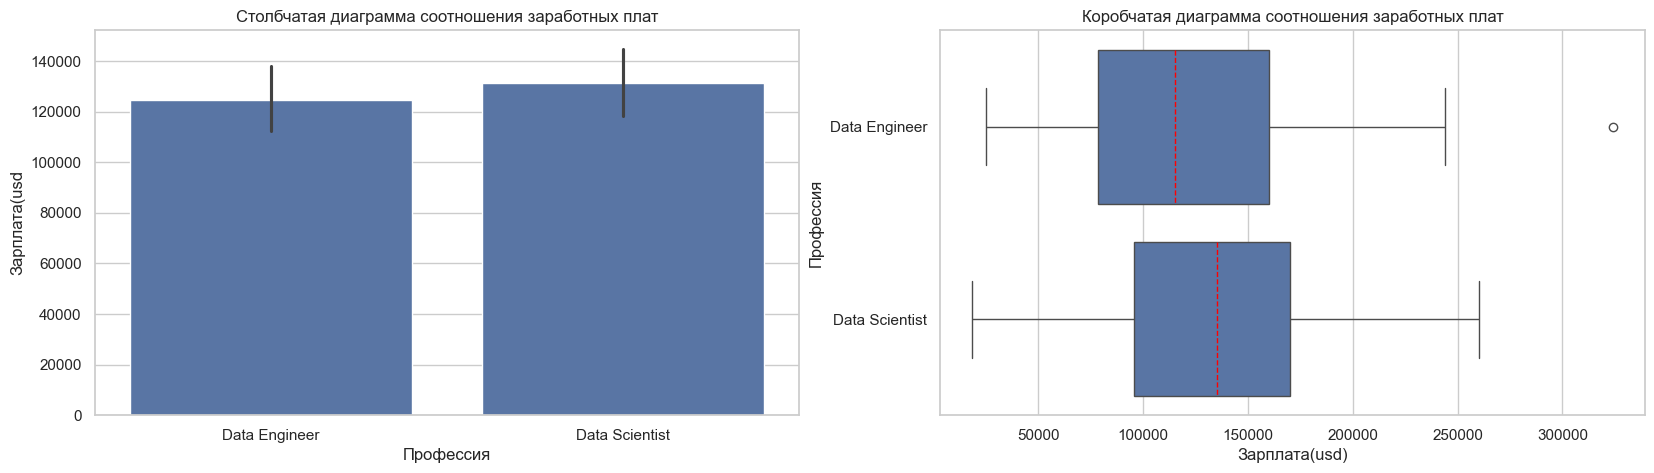

In [421]:
# Отфильтруем датасет sal_data, оставив нужные нам профессии и год
mask_DS_DE_2022 = sal_data[((sal_data['job_title'] == 'Data Scientist') | (sal_data['job_title'] == 'Data Engineer')) & (sal_data['work_year']==2022)] 

# построим два графика (столбчатую и коробчатую диаграммы)
fig, axes = plt.subplots(1, 2, figsize=(20,5))

barplot = sns.barplot(data=mask_DS_DE_2022, x='job_title', y='salary_in_usd', ax = axes[0])
barplot.set(xlabel = 'Профессия', ylabel = 'Зарплата(usd')
barplot.set_title('Столбчатая диаграмма соотношения заработных плат');

boxplot = sns.boxplot(mask_DS_DE_2022, x='salary_in_usd', y='job_title', orient='h', medianprops={"color": "red", "linestyle": '--'}, ax = axes[1])
boxplot.set(xlabel='Зарплата(usd)', ylabel='Профессия')
boxplot.set_title('Коробчатая диаграмма соотношения заработных плат');

### 2.2.2. На cтолбчатом графике видно, что максимальная зарпалат Дата Сиентиста немного выше, на коробчатом графике более наглядно показано распределение зарплат - нижняя и верхняя границы в профессии Дата Сиентист немного выше, медаинная зарплата выше соответственно.

Перед статистической проверки гипотез отделим вынесем профессию Data Engieneer в отдельный датасет и проверим проверим нормальность распределения признака *'salary_in_usd'* 

***(на всякий случай)***

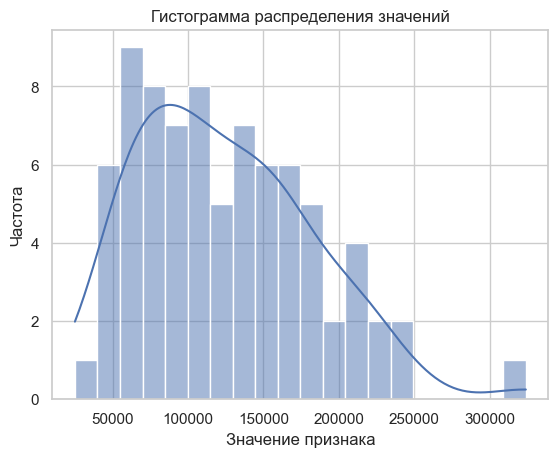

p-value = 0.007
Распределение не нормальное


In [422]:
# Маска, для профессии Data Engineer
mask_DE_2022 = sal_data[(sal_data['job_title'] == 'Data Engineer') & (sal_data['work_year']==2022)]

# Визуальная проверка нормальности распределения признака
ax = sns.histplot(mask_DE_2022['salary_in_usd'], bins=20, kde=True)
ax.set(xlabel='Значение признака', ylabel='Частота')
plt.title('Гистограмма распределения значений')
plt.show()

# Статистическая проверка нормальности распределения признака
_, p = stats.shapiro(mask_DE_2022['salary_in_usd'])
print('p-value = %.3f' % (p))
if p <= alpha:
    print('Распределение не нормальное')
else:
    print('Распределение нормальное')    


дял проверки статистической гипотезы **воспользуемся U-Критерием Манна-Уитни**

Нулевая гипотеза

***m1 = m2***

Альтернативная гипотеза

***m1 ≠ m2***

In [423]:
_, p = stats.mannwhitneyu(mask_DS_2022['salary_in_usd'], mask_DE_2022['salary_in_usd'])

print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

p-value = 0.319
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


## Раздел 2.3. Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?

### 2.3.1. Визуализируем датасет mask_DS

Text(0.5, 1.0, 'Диаграмма соотношения заработных плат в зависимости от размера компании')

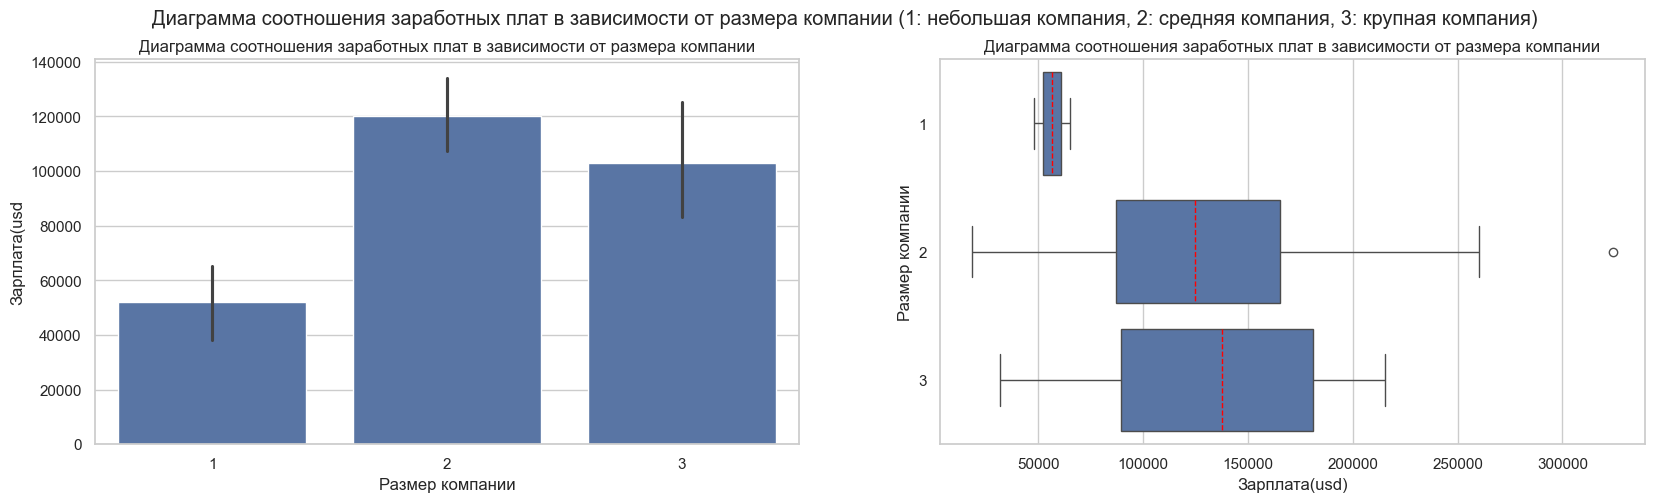

In [424]:
fig, axes = plt.subplots(1, 2, figsize=(20,5))
fig.suptitle('Диаграмма соотношения заработных плат в зависимости от размера компании (1: небольшая компания, 2: средняя компания, 3: крупная компания)')

barplot = sns.barplot(data=mask_DS, x='company_size', y='salary_in_usd', ax = axes[0])
barplot.set(xlabel = 'Размер компании', ylabel = 'Зарплата(usd')
barplot.set_title('Диаграмма соотношения заработных плат в зависимости от размера компании')

boxplot = sns.boxplot(mask_DS_DE_2022, x='salary_in_usd', y='company_size', orient='h', medianprops={"color": "red", "linestyle": '--'}, ax = axes[1])
boxplot.set(xlabel='Зарплата(usd)', ylabel='Размер компании')
boxplot.set_title('Диаграмма соотношения заработных плат в зависимости от размера компании')

### 2.3.2. На графиках четко видно, что зарпалты Дата Сиентистов в больших и средних компаниях превышают зарплаты в малеьних компаниях


***Для упрощения анализа создадим дополнительный признак, отражающий уровень заработной платы***

*Для этого создадим категориальный признак salary_rank, где уровень зарплаты будет разбит на категории:*
- 1 - уровень зарплаты <= 50000 usd
- 2 - уровень зарплаты от 50000 usd до 70000 usd (включительно)
- 3 - уровень зарплаты > 70000 usd

In [428]:
def salary_level(data):
    if data <= 50000:
        return 1
    elif 50000 < data <= 100000:
        return 2
    else:
        return 3
    
mask_DS['salary_rank'] = mask_DS['salary_in_usd'].apply(salary_level)

C:\Users\User\AppData\Local\Temp\ipykernel_21348\1188295668.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mask_DS['salary_rank'] = mask_DS['salary_in_usd'].apply(salary_level)


**Сделаем выборку по рангу компании из 20 человек.**

In [429]:
# Выборки из 20 человек в компаниях (1 - маленькая, 2 - средняя, 3 - крупная)
mask_DS_cs1 = mask_DS[(mask_DS['company_size'] == 1)][:20]
mask_DS_cs2 = mask_DS[(mask_DS['company_size'] == 2)][:20]
mask_DS_cs3 = mask_DS[(mask_DS['company_size'] == 3)][:20]

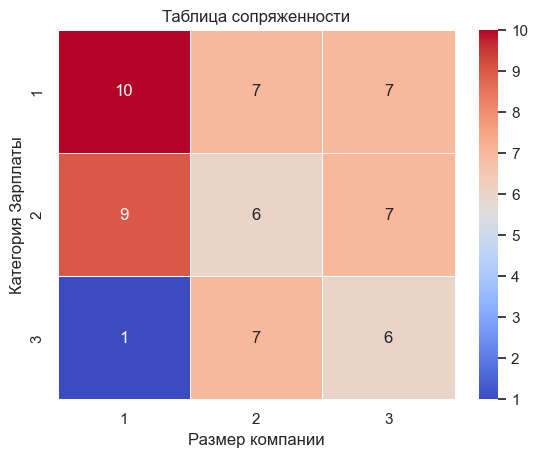

In [430]:
#Общая таблица выборок для визоального анализа
DS_concat_cs = pd.concat(
    [mask_DS_cs1 , mask_DS_cs2, mask_DS_cs3],
    ignore_index=True
)

cross_tab = pd.crosstab(index=DS_concat_cs['salary_rank'], columns=DS_concat_cs['company_size'])
ax = sns.heatmap(cross_tab, annot=True, linewidth=.5, fmt='.0f', cmap="coolwarm")
ax.set(xlabel='Размер компании', ylabel='Категория Зарплаты')
plt.title('Таблица сопряженности')
plt.show()


### 2.3.3. Таблица сопряженности указывает на то, что зарплаты в маленьких компаниях ниже чем в средних и крупных компаниях

***Для определения взаимосвязи между размером компании и зарплатой Дата Сиентиста выполним проверку с приминением критерия ХИ-квадрат***


Нулевая гипотеза:

***Признаки salary_rank и company_size независимы***

***Признаки salary_rank и company_size взаимосвязаны***

In [431]:
_, p, _, _ = stats.chi2_contingency(cross_tab)

print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

p-value = 0.213
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


## Раздел 2.4. Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

### 2.4.1. Выполним фильтрацию профессий. Затем создадим выборки из каждого типаразмера компании (25 человек)

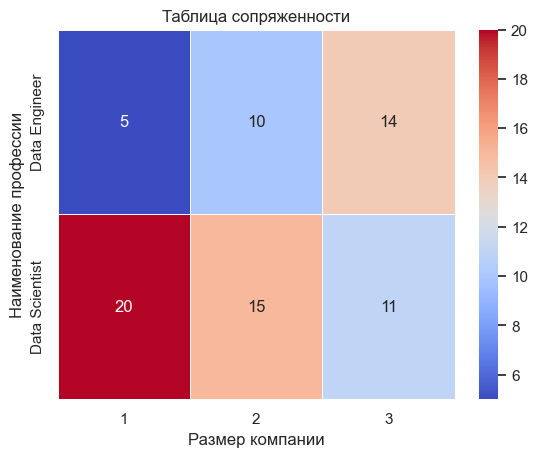

In [432]:
# Общий датасет с нужными профессиями (Data Scientist, Data Engineer)
mask_DS_DE = sal_data[((sal_data['job_title'] == 'Data Scientist') | (sal_data['job_title'] == 'Data Engineer'))]

# Выборки из 25 селовек по размеру компании
mask_DS_DE_cs1 = mask_DS_DE[(mask_DS_DE['company_size'] == 1)][:25]
mask_DS_DE_cs2 = mask_DS_DE[(mask_DS_DE['company_size'] == 2)][:25]
mask_DS_DE_cs3 = mask_DS_DE[(mask_DS_DE['company_size'] == 3)][:25]

# Общая таблица выборок
DS_DE_concat_cs = pd.concat(
    [mask_DS_DE_cs1 , mask_DS_DE_cs2, mask_DS_DE_cs3],
    ignore_index=True
)

# Корсс-таблица, визуализация результатов
cross_tab = pd.crosstab(index=DS_DE_concat_cs['job_title'], columns=DS_DE_concat_cs['company_size'])
ax = sns.heatmap(cross_tab, annot=True, linewidth=.5, fmt='.0f', cmap="coolwarm")
ax.set(xlabel='Размер компании', ylabel='Наименование профессии')
plt.title('Таблица сопряженности')
plt.show()

### 2.4.2. Визуализация четко показывает преобладание Дата сиентистов в малых компаниях (1), в средних и крупных компаниях распределение профессий примерно одинаково

***Для определения взаимосвязи между размером компании и зарплатой Дата Сиентиста выполним проверку с приминением критерия ХИ-квадрат***


Нулевая гипотеза:

***Признаки job_title и company_size независимы***

***Признаки job_title и company_size взаимосвязаны***

In [433]:
_, p, _, _ = stats.chi2_contingency(cross_tab)

print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

p-value = 0.032
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.


## Выводы по разделу 2:

*2.1. Визуальный анализ выборки показывает, что зарплаты Дата Сиентистов в 2022 году превышают зарпалты 20-го и 21-го года, однако статистический тест показывает, что вероятность ошибки превышает 5%, что противоресит правилам отвержения нулевой гипотизы.*

***Соответственно мы не можем однозначно утверждать, что в сфере Data Science наблюдается ежегодный рост зарплат***


*2.2. На cтолбчатом графике видно, что максимальная зарпалат Дата Сиентиста немного выше, на коробчатом графике более наглядно показано распределение зарплат - нижняя и верхняя границы в профессии Дата Сиентист немного выше, медаинная зарплата выше соответственно. Статистический тест не отвергает нулевую гипотезу m1=m2.*

***Соответственно можем сделать вывод, что запрлаты Дата Сиентиста и Дата Инженера примерно одинаковы***

*2.3. Визуальный анализ выборки четко показывает, что зарплаты Дата Сиентистов в больших и средних компаниях превышают зарплаты в малеьних компаниях. Однако статистический анализ показывает, что признаки salary_rank и company_size независимы*

***Соответственно можем сделать вывод, что зарплаты Дата сиентистов не сильно зависят от размера компании***

*2.4. Визуальный анализ выборки четко показывает преобладание Дата сиентистов в малых компаниях (1), в средних и крупных компаниях распределение профессий примерно одинаково. Статистический тест отвергает нулевую гипотезу p-value <= a*

***Соответственно можем однозначно утверждать, что между наличием должностей Data Scientist и Data Engineer и размером компании (company_size) есть сильная взаимосвзять***


## Раздел 3. Дополнительные исследования

## 3.1. Проверим соотношение заработной платы Дата Сиентиста и опыта работы

### 3.1.1. Воспользуемся маской (mask_DS) для визуализации признаков

Text(0.5, 1.0, 'Диаграмма соотношения заработных плат в зависимости от размера компании')

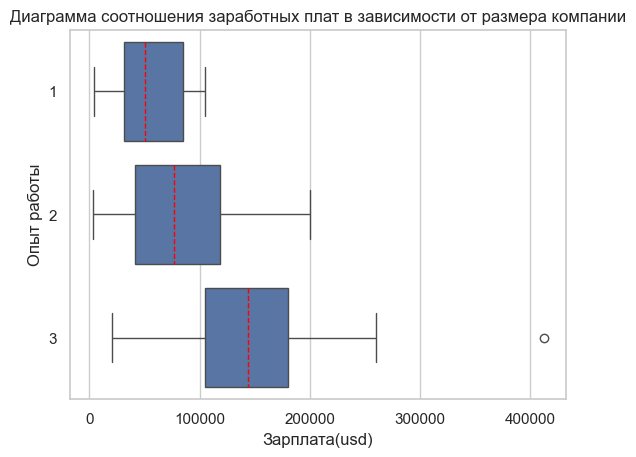

In [434]:
boxplot = sns.boxplot(mask_DS, x='salary_in_usd', y='experience_level', orient='h', medianprops={"color": "red", "linestyle": '--'})
boxplot.set(xlabel='Зарплата(usd)', ylabel='Опыт работы')
boxplot.set_title('Диаграмма соотношения заработных плат в зависимости от размера компании')

**Наблюдается рост зарплат с увиличением опыта работы и ранга специалиста**

### 3.1.2. Создадим выборки (20 шт.) для каждой категории опыта работы

In [435]:
mask_DS_el_1 = mask_DS[(mask_DS['experience_level'] == 1)][:20]
mask_DS_el_2 = mask_DS[(mask_DS['experience_level'] == 2)][:20]
mask_DS_el_3 = mask_DS[(mask_DS['experience_level'] == 3)][:20]

### 3.1.3. Проверка нулевой гипотезы по методу Краскела-Уоллиса

Нулевая гипотеза для двух и более групп будет выглядеть следующим образом:

***m1 = m2 = m3*** *- зарплаты специалистов ранга (1 - EN, 2 - Mi, 3 - SE) равны*

Альтернативная гипотеза:

***m1 ≠ m2 ≠ m3*** *- зарплаты специалистов ранга (1 - EN, 2 - Mi, 3 - SE) не равны*

In [436]:
# проводим тест
_, p = stats.kruskal(mask_DS_el_1['salary_in_usd'], mask_DS_el_2['salary_in_usd'], mask_DS_el_3['salary_in_usd'])

print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))


p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.


## 3.2. Проверим соотношение заработной платы (Всех специалистов) и страну проживания специалиста. Рассмотрим 3 наиболее распространённые страны: США (US), GB (Великобритания), DE (Германия)

### 3.2.1. Создаём выборки из 20 человек

In [437]:

mask_US = sal_data[(sal_data['employee_residence'] == 'US')][:20] #Выборка для США
mask_GB = sal_data[(sal_data['employee_residence'] == 'GB')][:20] #Выборка для Великобритании
mask_DE = sal_data[(sal_data['employee_residence'] == 'DE')][:20] #Выборка для Германии

print('Средняя зарплата резидента США:', mask_US['salary_in_usd'].mean())
print('Средняя зарплата резидента Великобритании:', mask_GB['salary_in_usd'].mean())
print('Средняя зарплата резидента Германии:', mask_DE['salary_in_usd'].mean())

Средняя зарплата резидента США: 149050.0
Средняя зарплата резидента Великобритании: 83972.15
Средняя зарплата резидента Германии: 83284.2


**По средним показателям выборок, можно отметить, что среднии зарплаты в США больше, чем в Великобритании и Германии**

### 3.1.3. Проверка нулевой гипотезы по методу Краскела-Уоллиса

Нулевая гипотеза для двух и более групп будет выглядеть следующим образом:

***m1 = m2 = m3*** *- зарплаты специалистов - резидентов стран (США, Великобритания и Германия) равны*

Альтернативная гипотеза:

***m1 ≠ m2 ≠ m3*** *- зарплаты специалистов - резидентов стран (США, Великобритания и Германия) не равны*

In [438]:
# проводим тест
_, p = stats.kruskal(mask_US['salary_in_usd'], mask_GB['salary_in_usd'], mask_DE['salary_in_usd'])

print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('p-значение меньше, чем заданный уровень значимости {:.2f}. Отвергаем нулевую гипотезу.'.format(alpha))
else:
    print('p-значение больше, чем заданный уровень значимости {:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.'.format(alpha))

p-value = 0.001
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу.


## Выводы по разделу 3.1:

- **Визуальный анализ и статистический тест подтверждают взаимосвязть между заработной платой Дата Сиентиста и опытом работы. А также взаимосвязть между заработной платой всех специалистов и основной страной проживания**